In [2]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                        
import seaborn as sns 

from utils.util import find_max_epoch, print_size, training_loss, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm, get_mask_mcar

from imputers.DiffWaveImputer import DiffWaveImputer
from imputers.SSSDSAImputer import SSSDSAImputer
from imputers.SSSDS4Imputer import SSSDS4Imputer

import time
import gc

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json') 
                                                                                                                      
args = parser.parse_args(args=[])
print(args)

with open(args.config) as f:
    data = f.read()

config = json.loads(data)
print(config)

Namespace(config='./config/config_SSSDS4-sp500.json')
{'diffusion_config': {'T': 200, 'beta_0': 0.0001, 'beta_T': 0.02}, 'wavenet_config': {'in_channels': 6, 'out_channels': 6, 'num_res_layers': 36, 'res_channels': 128, 'skip_channels': 128, 'diffusion_step_embed_dim_in': 128, 'diffusion_step_embed_dim_mid': 512, 'diffusion_step_embed_dim_out': 512, 's4_lmax': 100, 's4_d_state': 64, 's4_dropout': 0.0, 's4_bidirectional': 1, 's4_layernorm': 1}, 'train_config': {'output_directory': './results/sp500/90', 'ckpt_iter': 'max', 'iters_per_ckpt': 500, 'iters_per_logging': 500, 'n_iters': 1000, 'learning_rate': 0.0002, 'only_generate_missing': 1, 'use_model': 2, 'masking': 'rm', 'missing_k': 20}, 'trainset_config': {'train_data_path': './datasets/sp500.npy', 'test_data_path': './datasets/sp500.npy', 'segment_length': 100, 'sampling_rate': 100}, 'gen_config': {'output_directory': './results/sp500/90', 'ckpt_path': './results/sp500/90/'}}


In [4]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  

global model_config



'------chose dataset------'
data_name = 'sp500'
# data_name = 'ETTh1'
# data_name = 'energy'
# data_name = 'mujoco'



if data_name == 'sp500':
    trainset_config['train_data_path'] = "./datasets/sp500.npy"
    
if data_name == 'energy':
    trainset_config['train_data_path'] = "./datasets/energy.npy"
    
if data_name == 'ETTh1':
    trainset_config['train_data_path'] = "./datasets/ETTh1.npy"
    
if data_name == 'mujoco':
    trainset_config['train_data_path'] = "./datasets/train_mujoco.npy"


model_config = config['wavenet_config']
    
    
if data_name == 'sp500':
    model_config['in_channels'] =  6   
    model_config['out_channels'] = 6   
    
if data_name == 'energy':
    model_config['in_channels'] =  26   
    model_config['out_channels'] = 26  
    
if data_name == 'ETTh1':
    model_config['in_channels'] =  7   
    model_config['out_channels'] = 7  
    
if data_name == 'mujoco':
    model_config['in_channels'] =  14   
    model_config['out_channels'] = 14  



model_config['num_res_layers'] = 18          

if data_name == 'energy':
    model_config['res_channels'] = 256            
    model_config['skip_channels'] =256 
else:
    model_config['res_channels'] = 128           
    model_config['skip_channels'] = 128
    

In [5]:
dh = diffusion_hyperparams
T, Alpha, Alpha_bar, Sigma = dh["T"], dh["Alpha"], dh["Alpha_bar"], dh["Sigma"]
Beta = 1 - Alpha


def get_acc_point(alphas_hat):
        """
            Calculate Acceleration Point, according to formula 27
        """
        abs_dist = torch.abs(torch.sqrt(alphas_hat) - 0.5)
        return abs_dist.argmin() + 1
    
T_acc = get_acc_point(Alpha_bar).item()
print( T_acc )

abs_dist = torch.abs(torch.sqrt(Alpha_bar[165]) - 0.5)

166


In [6]:
learning_rate = 0.0002

In [7]:
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        
net = SSSDS4Imputer(**model_config).cuda()   
print_size(net)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

SSSDS4Imputer Parameters: 7.547142M


In [8]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)

Number = training_data.shape[0]
Length = training_data.shape[1]
Attribute = training_data.shape[2]
print(Number, Length, Attribute)

training_data = torch.split( torch.tensor(training_data),split_size_or_sections=128) 


5775 30 6


In [9]:
def resfusion_x0_to_xt(x_0: torch.Tensor, alpha_hat_t: torch.Tensor, residual_term: torch.Tensor, noise: torch.Tensor) \
        -> torch.Tensor:
    """
    Compute x_t from x_0 with formula 20 from Resfusion
    :param x_0: the image without noise
    :param alpha_hat_t: the cumulated variance schedule at time t
    :param residual_term: the residual term
    :param noise: pure noise from N(0, 1)
    :return: the noised image x_t at step t
    """
    return (torch.sqrt(alpha_hat_t) * x_0 + (1 - torch.sqrt(alpha_hat_t)) * residual_term
            + torch.sqrt(1 - alpha_hat_t) * noise)


def ddpm_x0_to_xt(x_0: torch.Tensor, alpha_hat_t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
    """
    Compute x_t from x_0 using a closed form using theorem from original DDPM paper (Ho et al.)
    :param x_0: the image without noise
    :param alpha_hat_t: the cumulated variance schedule at time t
    :param noise: pure noise from N(0, 1)
    :return: the noised image x_t at step t
    """
    return torch.sqrt(alpha_hat_t) * x_0 + torch.sqrt(1 - alpha_hat_t) * noise

In [10]:
epoch = 200
n_iters = epoch * ( len(training_data) )

iters = 0
mr = 0.3

loss_list=[]
net = SSSDS4Imputer(**model_config).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [13]:
'-------training resnoise diffusion-------'
while iters < n_iters + 1:         
    for batch in training_data:          
        
        X_0 = batch.float().cuda()  
        B = X_0.shape[0]
        L = X_0.shape[1]
        D = X_0.shape[2]
        

        'missing patterns'
        missing_length = int( mr * L )
#         mask = get_mask_rm( X_0[0], missing_length)     
#         mask = get_mask_mnr( X_0[0], missing_length) 
#         mask = get_mask_bm( X_0[0], missing_length) 
        mask = get_mask_mcar( X_0[0], mr)  
    
        mask = mask.repeat(X_0.size()[0], 1, 1).float().cuda()
        X_0_hat = X_0*mask

        residual_term = X_0_hat - X_0 
        
        t: torch.Tensor = torch.randint(0, T_acc, (X_0.shape[0],) ).cuda()    
        alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()                    
        noise = torch.randn_like(X_0)
        
        x_t = resfusion_x0_to_xt(X_0, alpha_hat, residual_term, noise) 
        
        alpha = Alpha[t].reshape(-1, 1, 1).cuda() 
        beta = Beta[t].reshape(-1, 1, 1).cuda() 
        
        resnoise = noise + (1 - torch.sqrt(alpha)) * torch.sqrt(1 - alpha_hat) / beta * residual_term
        
    
     
        pred_resnoise = net( (x_t.permute(0, 2, 1), X_0.permute(0, 2, 1), mask.permute(0, 2, 1), t.view(B, 1),) ) 
        pred_resnoise = pred_resnoise.permute(0, 2, 1)
        
        optimizer.zero_grad()
        
        loss = F.mse_loss(input=pred_resnoise, target=resnoise )  

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iters += 1
         

9246
[0.0053374022245407104, 0.0033797926735132933, 0.0030520083382725716, 0.008132582530379295, 0.006829595658928156, 0.006452763453125954, 0.0058319359086453915, 0.005042531993240118, 0.005100364796817303, 0.004857505206018686, 0.005055501125752926, 0.004392361268401146, 0.0036843896377831697, 0.004808233585208654, 0.00531212380155921, 0.003724948735907674, 0.003207885194569826, 0.0044289566576480865, 0.006192872300744057, 0.013244385831058025]
[0.07305752681648012, 0.05813598432565921, 0.055244984734114745, 0.09018083238903539, 0.08264136772179026, 0.08032909468633363, 0.07636711274262889, 0.07101078786522592, 0.07141683832834735, 0.06969580479497088, 0.0711020472683658, 0.06627489168909403, 0.06069917328747707, 0.06934142762597735, 0.07288431793986419, 0.06103235810541548, 0.05663819554478961, 0.06655040689318201, 0.07869480478877915, 0.11508425535692546]


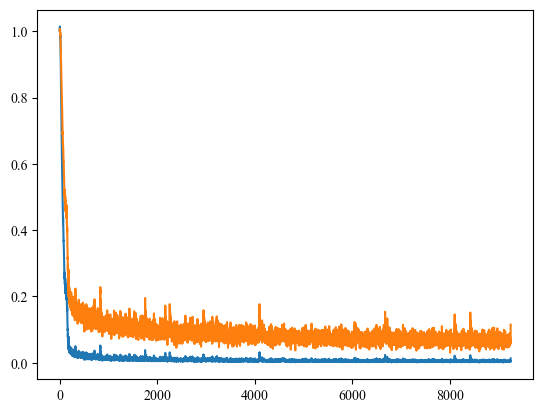

In [24]:
print(len(loss_list))
rmse = list( map(lambda x: x ** (1/2), loss_list) )

print( loss_list[-20 : ] )
print( rmse[-20 : ] )

plt.figure()
plt.plot(loss_list)
plt.plot(rmse)

In [ ]:
'save and load model'
# torch.save( net.state_dict(),"./results/sp500_resfusion_mcar0.3.pth" )
# torch.save( net.state_dict(),"./results/sp500_resfusion_mcar0.6.pth" )
# torch.save( net.state_dict(),"./results/sp500_resfusion_mnr0.3.pth" )
# torch.save( net.state_dict(),"./results/sp500_resfusion_mnr0.6.pth" )


# torch.save( net.state_dict(),"./results/ETTh1_resfusion_mcar0.3.pth" )
# torch.save( net.state_dict(),"./results/ETTh1_resfusion_mcar0.6.pth" )
# torch.save( net.state_dict(),"./results/ETTh1_resfusion_mnr0.3.pth" )
# torch.save( net.state_dict(),"./results/ETTh1_resfusion_mnr0.6.pth" )


# torch.save( net.state_dict(),"./results/energy_resfusion_mcar0.3.pth" )
# torch.save( net.state_dict(),"./results/energy_resfusion_mcar0.6.pth" )
# torch.save( net.state_dict(),"./results/energy_resfusion_mnr0.3.pth" )
# torch.save( net.state_dict(),"./results/energy_resfusion_mnr0.6.pth" )


# torch.save( net.state_dict(),"./results/mujoco_resfusion_mcar0.3.pth" )
# torch.save( net.state_dict(),"./results/mujoco_resfusion_mcar0.6.pth" )
# torch.save( net.state_dict(),"./results/mujoco_resfusion_mnr0.3.pth" )
# torch.save( net.state_dict(),"./results/mujoco_resfusion_mnr0.6.pth" )


net = SSSDS4Imputer(**model_config).cuda()
net.load_state_dict(torch.load( "./results/sp500_resfusion_mcar0.3.pth" ))
# net.load_state_dict(torch.load( "./results/sp500_resfusion_mcar0.6.pth" ))
# net.load_state_dict(torch.load( "./results/sp500_resfusion_mnr0.3.pth" ))
# net.load_state_dict(torch.load( "./results/sp500_resfusion_mnr0.6.pth" ))


# net.load_state_dict(torch.load( "./results/ETTh1_resfusion_mcar0.3.pth" ))
# net.load_state_dict(torch.load( "./results/ETTh1_resfusion_mcar0.6.pth" ))
# net.load_state_dict(torch.load( "./results/ETTh1_resfusion_mnr0.3.pth" ))
# net.load_state_dict(torch.load( "./results/ETTh1_resfusion_mnr0.6.pth" ))


# net.load_state_dict(torch.load( "./results/energy_resfusion_mcar0.3.pth" ))
# net.load_state_dict(torch.load( "./results/energy_resfusion_mcar0.6.pth" ))
# net.load_state_dict(torch.load( "./results/energy_resfusion_mnr0.3.pth" ))
# net.load_state_dict(torch.load( "./results/energy_resfusion_mnr0.6.pth" ))


# net.load_state_dict(torch.load( "./results/mujoco_resfusion_mcar0.3.pth" ))
# net.load_state_dict(torch.load( "./results/mujoco_resfusion_mcar0.6.pth" ))
# net.load_state_dict(torch.load( "./results/mujoco_resfusion_mnr0.3.pth" ))
# net.load_state_dict(torch.load( "./results/mujoco_resfusion_mnr0.6.pth" ))

net.eval()

In [11]:
def std_normal(size):
    """
    Generate the standard Gaussian variable of a certain size
    """
    return torch.normal(0, 1, size=size).cuda()

size = (Number, Attribute, Length )
noise = std_normal(size)

X_0_hat = torch.randn_like(noise)
alpha_hat = Alpha_bar[T_acc - 1].reshape(-1, 1, 1).cuda() 
x = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)    

In [28]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
training_data = torch.from_numpy(training_data).float().cuda()

size = (Number, Length, Attribute )
noise = std_normal(size)


# Mask = get_mask_rm( noise[0], missing_length)     
# Mask = get_mask_mnr( X_0[0], missing_length) 
# Mask = get_mask_bm( X_0[0], missing_length) 
Mask = get_mask_mcar( noise[0], mr)

Mask = Mask.repeat(noise.size()[0], 1, 1).float().cuda()

X_0_hat = training_data.reshape(-1, Length, Attribute) * Mask  
alpha_hat = Alpha_bar[T_acc - 1].reshape(-1, 1, 1).cuda() 
X_T = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)     


In [29]:
'-------sampling resnoise diffusion-------'


X = X_T.permute(0, 2, 1)

'DDPM sampler'
start_time = time.time()
with torch.no_grad():      
        for t in range( T_acc - 1, -1, -1):      
            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()      
            epsilon_theta = net((X, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), diffusion_steps,))    
            alpha = Alpha[t].reshape(-1, 1, 1).cuda() 
            beta = Beta[t].reshape(-1, 1, 1).cuda() 
            alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()      
            sigma = Sigma[t].reshape(-1, 1, 1).cuda()              
            X = (X - (1 - alpha) / torch.sqrt(1 - alpha_hat) * epsilon_theta) / torch.sqrt(alpha)
            if t > 0:
                X = X + sigma * std_normal( (Number, Attribute, Length ))


    
'DDIM sampler'    
# start_time = time.time()
# with torch.no_grad():      
#         for t in range(T_acc - 1 , 0, -1):     
#             diffusion_steps = (t * torch.ones((size[0], 1))).cuda()       
#             epsilon_theta = net((X, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), diffusion_steps,))  
#             alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()    
#             alpha_hat_t_minus_1 = Alpha_bar[t-1].reshape(-1, 1, 1).cuda() 
#             X = ( torch.sqrt( alpha_hat_t_minus_1 ) * (X - torch.sqrt(1-alpha_hat) * epsilon_theta) ) / torch.sqrt(alpha_hat) + \
#                                                                                               torch.sqrt(1-alpha_hat_t_minus_1)* epsilon_theta


end_time = time.time()
execution_time = end_time - start_time   
print(execution_time)  

152.60702896118164


In [16]:
'-------RMSE-------'
result = X.permute(0, 2, 1)
gt = training_data
loss = nn.MSELoss()
output4 = loss(input=result*(1-Mask), target=gt*(1-Mask)  )      
print(output4, torch.sqrt(output4))

tensor(5.4780e-05, device='cuda:0') tensor(0.0074, device='cuda:0')


In [30]:
def visualization2(ori, gen):
    
    Number = ori.shape[0]
    
    max_sample = min([4000, Number])       
    idx = np.random.permutation(Number)[ :max_sample]

    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]

    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 

    concat_data = np.concatenate((ori1, gen1), axis=0)
    
    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=30,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=30)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)
    

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 8000 samples in 0.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.017084
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.802132
[t-SNE] KL divergence after 500 iterations: 1.157110


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

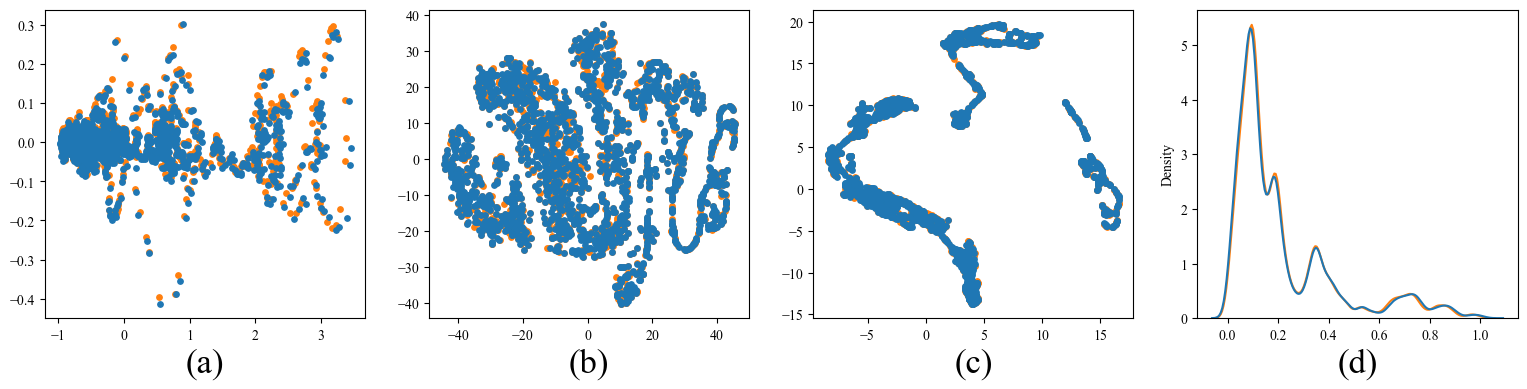

In [31]:
ori = training_data.cpu()
gen = X.permute(0, 2, 1).cpu().numpy()
visualization2(ori, gen)

In [13]:
'----------Reflow-----------'

import torch
from torch.nn import functional as F
from torch.distributions.normal import Normal

In [16]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
training_data = torch.from_numpy(training_data).float().cuda()

size = (Number, Length, Attribute )
noise = std_normal(size)

# mask = get_mask_rm( noise[0], 9)      
# mask = get_mask_mnr( X_0[0], 9) 
# mask = get_mask_bm( X_0[0], 9) 
Mask = get_mask_mcar( noise[0], 0.3)

Mask = Mask.repeat(noise.size()[0], 1, 1).float().cuda()
np.random.shuffle(training_data)
X_0_hat = training_data.reshape(-1, Length, Attribute)*Mask
alpha_hat = Alpha_bar[T_acc - 1].reshape(-1, 1, 1).cuda() 
X_T_acc = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)    


C:\Users\PC123\AppData\Local\Temp\ipykernel_21324\2217161368.py:14: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(training_data)


In [17]:
dl_X_T_acc = torch.split( torch.tensor(X_T_acc),split_size_or_sections=128) 
dl_X_0_hat = torch.split( torch.tensor(X_0_hat),split_size_or_sections=128)
dl_Mask = torch.split( torch.tensor(Mask),split_size_or_sections=128)

C:\Users\PC123\AppData\Local\Temp\ipykernel_21324\2387625009.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl_X_T_acc = torch.split( torch.tensor(X_T_acc),split_size_or_sections=128)
C:\Users\PC123\AppData\Local\Temp\ipykernel_21324\2387625009.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl_X_0_hat = torch.split( torch.tensor(X_0_hat),split_size_or_sections=128)
C:\Users\PC123\AppData\Local\Temp\ipykernel_21324\2387625009.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl_Mask = torch.split( torch.tensor(Mask),split_size_

In [18]:
gc.collect()
torch.cuda.empty_cache()

teacher_unet = SSSDS4Imputer(**model_config).cuda()
teacher_unet.load_state_dict(torch.load( "./results/sp500_resfusion_mcar0.3.pth") )
teacher_unet.eval()       


student_unet = SSSDS4Imputer(**model_config).cuda()
student_unet.load_state_dict(torch.load( "./results/sp500_resfusion_mcar0.3.pth"))
student_unet.train()       

optimizer = torch.optim.Adam(student_unet.parameters())
# optimizer = torch.optim.Adam(student_unet.parameters(), lr=1e-4) 

In [86]:
# X = X_T_acc.permute(0, 2, 1)
# trajectory_ddpm = []
# with torch.no_grad():      
#     for t in range(T_acc - 1, -1, -1):     
#         trajectory_ddpm.append(X)
#         diffusion_steps = (t * torch.ones((X.shape[0], 1))).cuda()         
#         epsilon_theta = teacher_unet((X, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), diffusion_steps,)) 
#         alpha = Alpha[t].reshape(-1, 1, 1).cuda() 
#         beta = Beta[t].reshape(-1, 1, 1).cuda() 
#         alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()      
#         sigma = Sigma[t].reshape(-1, 1, 1).cuda()      
#         X = (X - (1 - alpha) / torch.sqrt(1 - alpha_hat) * epsilon_theta) / torch.sqrt(alpha)
#         if t > 0:
#             X = X + sigma * std_normal( X.shape )    

# trajectory_ddpm.append(X)
# X_ddpm = X



X = X_T_acc.permute(0, 2, 1)
trajectory_ddim = []
with torch.no_grad():      
    for t in range(T_acc - 1, 0, -1):     
        trajectory_ddim.append(X)
        diffusion_steps = (t * torch.ones((X.shape[0], 1))).cuda()      
        epsilon_theta = teacher_unet((X, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), diffusion_steps,)) 
        alpha_hat = Alpha_bar[t].reshape(-1, 1, 1).cuda()      
        alpha_hat_t_minus_1 = Alpha_bar[t-1].reshape(-1, 1, 1).cuda() 
        X = ( torch.sqrt( alpha_hat_t_minus_1 ) * (X - torch.sqrt(1-alpha_hat) * epsilon_theta) ) / torch.sqrt(alpha_hat) + \
                                                                                              torch.sqrt(1-alpha_hat_t_minus_1)* epsilon_theta
        
trajectory_ddim.append(X)
X_ddim = X

In [19]:
# # X_1_gen = X_ddpm
X_1_gen = X_ddim

dl_X_1_gen = torch.split( torch.tensor(X_1_gen),split_size_or_sections=128) 

In [88]:
min_step_percent=0
max_step_percent=1

min_step = int( T_acc * min_step_percent)
max_step = int( T_acc * max_step_percent)

iters=0   
reflow_epoch=100       

loss_list = []

166
0 166


In [89]:
'---------training Reflow-------------'
while iters < reflow_epoch + 1:         
    for i in range(0, len(dl_X_T_acc)): 
        x_0 = dl_X_T_acc[i].float().cuda()  
        x_1 = dl_X_1_gen[i].float().cuda()  
        x_0_hat = dl_X_0_hat[i].float().cuda()  
        mask = dl_Mask[i].float().cuda()  
        B = x_0.shape[0]
        
        t = torch.randint(min_step, max_step + 1, (x_0.shape[0],) ).cuda()          
        t_view = t.view(B, 1, 1)
        x_t = ( t_view/T_acc ) * x_1 + ( 1-t_view/T_acc ) * x_0.permute(0, 2, 1)

        pred_v = student_unet( (x_t, x_0_hat.permute(0, 2, 1), mask.permute(0, 2, 1), t.view(B, 1),) )   

        loss = F.mse_loss(pred_v, ( x_0.permute(0, 2, 1)- x_1 ))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
           
    iters += 1


1426


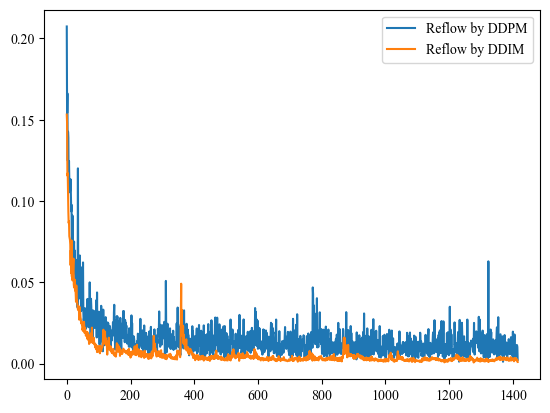

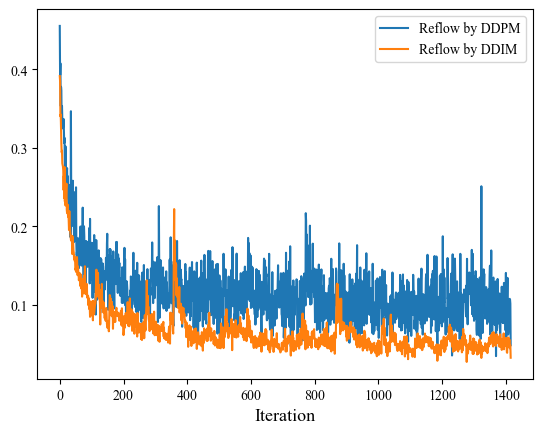

In [90]:
# loss_ddpm = loss_list
loss_ddim = loss_list


plt.figure()
plt.plot(loss_ddpm[10:],label='Reflow by DDPM' )
plt.plot(loss_ddim[10:],label='Reflow by DDIM')
plt.legend()

rmse1 = list( map(lambda x: x ** (1/2), loss_ddpm) )
rmse2 = list( map(lambda x: x ** (1/2), loss_ddim) )

plt.figure()
plt.plot(rmse1[10:],label='Reflow by DDPM')
plt.plot(rmse2[10:],label='Reflow by DDIM')
plt.xlabel('Iteration',fontsize=13)
plt.legend()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# torch.save( student_unet.state_dict(),"./results/sp500_reflow_mcar0.3.pth" )

student_unet = SSSDS4Imputer(**model_config).cuda()
student_unet.load_state_dict(torch.load( "./results/sp500_reflow_mcar0.3.pth" ))

student_unet.cuda()
student_unet.eval()

In [23]:
X_t = X_T_acc.permute(0, 2, 1).cuda()
bs = X_t.shape[0]

eps = 0
n_steps = 30      

t = torch.linspace(eps, 1 - eps, n_steps + 1).cuda()
t = t * T_acc 
t= t.int()

t0 = t[0] * torch.ones((X_t.shape[0], 1)).cuda()


In [24]:
'--------sampling Reflow--------'
start_time = time.time()

trajectory_reflow = []
for i in range(1, len(t)):
    trajectory_reflow.append(X_t)
    t_prev = t[i - 1]
    t_prev = t_prev * torch.ones((X_t.shape[0], 1)).cuda()   

    with torch.no_grad():         
        pred_v = student_unet( (X_t, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), t_prev.view(bs, 1),) )   
        
    X_t = X_t + ( ( t[i-1] - t[i] )/T_acc ) * pred_v 

trajectory_reflow.append(X_t)


end_time = time.time()
execution_time = end_time - start_time  
print(execution_time)  

28.76397943496704


In [25]:
'--------RMSE--------'
gt = training_data
result = X_t.permute(0, 2, 1)
loss = nn.MSELoss()
output4 = loss(input=result*(1-Mask), target=gt*(1-Mask)  )      
print(output4, torch.sqrt(output4))

tensor(0.0002, device='cuda:0') tensor(0.0123, device='cuda:0')


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 0.303s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.019326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.626762
[t-SNE] KL divergence after 500 iterations: 1.107974


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

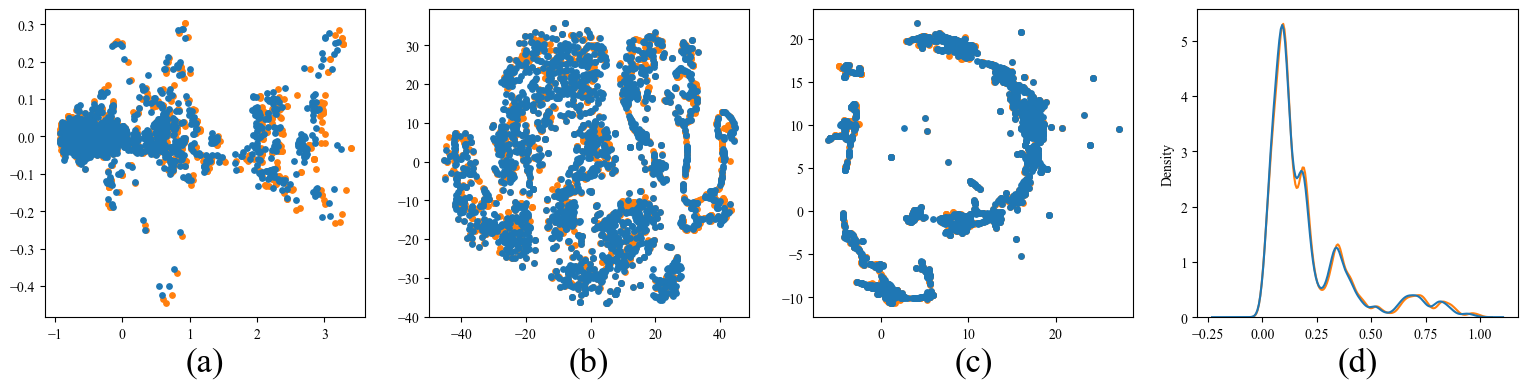

In [30]:
ori = training_data.cpu()
gen = X_t.permute(0, 2, 1).cpu().numpy()
visualization2(ori, gen)

In [18]:
'-------sampling trajectories--------'

'element-wise'

num_trajectories = 10
indices_x = np.random.choice(trajectory_reflow[0][0].shape[0], num_trajectories)   
indices_y = np.random.choice(trajectory_reflow[0][0].shape[1], num_trajectories)

indices_sample = np.random.choice(trajectory_reflow[0].shape[0], num_trajectories)  

time1 = range(0,len(trajectory_ddpm))
value1 = []
for i in range(len(trajectory_ddpm)):
    value1.append( trajectory_ddpm[i][ 0, indices_x, indices_y ].cpu() )

    
time2 = range(0,len(trajectory_ddim))
value2 = []
for i in range(len(trajectory_ddim)):
    value2.append( trajectory_ddim[i][ 0, indices_x, indices_y ].cpu() )


time3 = range(0,len(trajectory_reflow))
value3 = []
for i in range(len(trajectory_reflow)):
    value3.append( trajectory_reflow[i][ 0, indices_x, indices_y ].cpu() )


'sample-wise'
time4 = range(0,len(trajectory_ddpm))
value4 = []
for i in range(len(trajectory_ddpm)):
    value = trajectory_ddpm[i][indices_sample]
    value = value.mean(2).mean(1)
    value4.append(value.cpu())

    
time5 = range(0,len(trajectory_ddim))
value5 = []
for i in range(len(trajectory_ddim)):
    value = trajectory_ddim[i][indices_sample]
    value = value.mean(2).mean(1)
    value5.append(value.cpu())

time6 = range(0,len(trajectory_reflow))
value6 = []
for i in range(len(trajectory_reflow)):
    value = trajectory_reflow[i][indices_sample]
    value = value.mean(2).mean(1)
    value6.append(value.cpu())


In [28]:
from scipy.integrate import quad


def compute_velocity(z_t, z_t_minus_1, delta_t):
    v_t = (z_t_minus_1 - z_t) / delta_t
    return v_t
                        
def straightness_measurement(Z_t_list, compute_velocity, use_velocity_fn):
    """
    Measure the straightness of a trajectory given initial and final positions (Z_0, Z_1)
    and a velocity function v(Z_t, t).
    """

    Z_0 = Z_t_list[-1]   
    Z_1 = Z_t_list[0]
    

    def integrand(t):

        i = t * (len(Z_t_list) - 1)
        delta_t = 1 / len(Z_t_list) 

        if use_velocity_fn:           
            if t == 0:
                v_t = 0
            else:                  
                v_t = compute_velocity(Z_t_list[int(i)], Z_t_list[int(i-1)], delta_t)  
        else:
            v_t = Z_t_list[int(i)]     
            
        deviation = (Z_1 - Z_0) - v_t
        deviation = np.array(deviation.cpu()) 
        
        return np.mean(deviation ** 2)


    S_Z, _ = np.log(quad(integrand, 0, 1))
    return S_Z


straightness_value_ddpm = straightness_measurement( trajectory_ddpm, compute_velocity, use_velocity_fn=True)
straightness_value_ddim = straightness_measurement( trajectory_ddim, compute_velocity, use_velocity_fn=True)
straightness_value_reflow = straightness_measurement( trajectory_reflow, compute_velocity, use_velocity_fn=True)
print(straightness_value_ddpm, straightness_value_ddim, straightness_value_reflow )

C:\Users\PC123\AppData\Local\Temp\ipykernel_8868\3856962783.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  S_Z, _ = np.log(quad(integrand, 0, 1))


5.449200331148091 -2.688898736161439 -3.4020322734757835


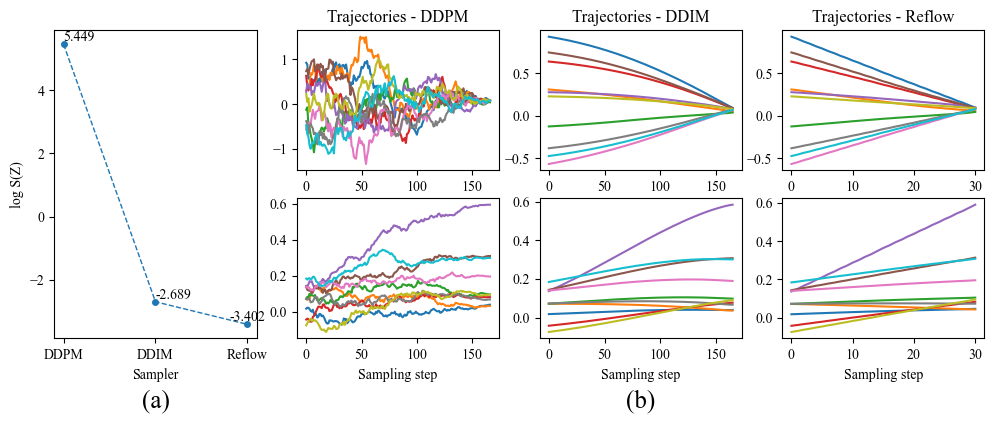

In [30]:
models = ["DDPM", "DDIM", 'Reflow']
s_value = [straightness_value_ddpm, straightness_value_ddim, straightness_value_reflow ]

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.plot(models, s_value,'o--',  linewidth=1, markersize=4)
plt.ylabel('log S(Z)')


for i in range(len(models)-1):
    plt.text(i, s_value[i]+0.1, round(s_value[i],3))
plt.text(2-0.2, s_value[2]+0.1, round(s_value[2],3))
plt.xlabel('Sampler')
    
plt.title('(a)',fontsize=18, x=0.5, y=-0.25) 
    
    
    
plt.subplot(2,4,2)
plt.plot( time1, value1)
plt.title('Trajectories - DDPM')

plt.subplot(2,4,3)
plt.plot( time2, value2)
plt.title('Trajectories - DDIM')

plt.subplot(2,4,4)
plt.plot( time3, value3)
plt.title('Trajectories - Reflow')


plt.subplot(2,4,6)
plt.plot( time4, value4)
plt.xlabel('Sampling step')

plt.subplot(2,4,7)
plt.plot( time5, value5)
plt.xlabel('Sampling step')

plt.title('(b)',fontsize=18, x=0.5, y=-0.55) 


plt.subplot(2,4,8)
plt.plot( time6, value6)
plt.xlabel('Sampling step')



In [24]:
'--------distillation---------'

gc.collect()
torch.cuda.empty_cache()

teacher_unet = SSSDS4Imputer(**model_config).cuda()
teacher_unet.load_state_dict(torch.load( "./results/sp500_reflow_mcar0.3.pth" ))

student_unet = SSSDS4Imputer(**model_config).cuda()
student_unet.load_state_dict(torch.load( "./results/sp500_reflow_mcar0.3.pth" ))


student_unet.cuda()
teacher_unet.cuda()

student_unet.train()
teacher_unet.eval()
# optimizer = torch.optim.Adam(student_unet.parameters())
optimizer = torch.optim.Adam(student_unet.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam(student_unet.parameters(), lr=1e-5)

In [29]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
training_data = torch.from_numpy(training_data).float().cuda()
size = (Number, Length, Attribute )
noise = std_normal(size)

# mask = get_mask_rm( noise[0], 9)     
# mask = get_mask_mnr( X_0[0], 9) 
# mask = get_mask_bm( X_0[0], 9) 
Mask = get_mask_mcar( noise[0], 0.3)

Mask = Mask.repeat(noise.size()[0], 1, 1).float().cuda()

np.random.shuffle(training_data)
X_0_hat = training_data.reshape(-1, Length, Attribute)*Mask
alpha_hat = Alpha_bar[T_acc - 1].reshape(-1, 1, 1).cuda() 
X_T_acc = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)    


C:\Users\PC123\AppData\Local\Temp\ipykernel_16944\2094227814.py:14: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(training_data)


In [31]:
dl_X_T_acc = torch.split( torch.tensor(X_T_acc),split_size_or_sections=128) 
dl_X_0_hat = torch.split( torch.tensor(X_0_hat),split_size_or_sections=128)
dl_Mask = torch.split( torch.tensor(Mask),split_size_or_sections=128)

In [22]:
X_t = X_T_acc.permute(0, 2, 1).cuda()
reflow_step = 1
n_steps = 30
eps = 0
t = torch.linspace(eps, 1 - eps, n_steps + 1).cuda()
t = t * T_acc 
t= t.int()

In [22]:
with torch.no_grad():  
    for i in range(1, len(t)):

        t_prev = t[i - 1]
        t_prev = t_prev * torch.ones((X_t.shape[0], 1)).cuda()   

        with torch.no_grad():         
            pred_v = teacher_unet( (X_t, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), t_prev.view(Number, 1),) )   

        X_t = X_t + ( ( t[i-1] - t[i] )/T_acc ) * pred_v 


X_1_reflow = X_t.permute(0, 2, 1)
dl_X_1_reflow = torch.split( torch.tensor(X_1_reflow),split_size_or_sections=128) 

In [29]:
gt = training_data
result = X_t.permute(0, 2, 1)
loss = nn.MSELoss()
output4 = loss(input=result*(1-Mask), target=gt*(1-Mask)  )       

tensor(0.0002, device='cuda:0') tensor(0.0127, device='cuda:0')


In [ ]:
iters=0   
n_iters=200 
distill_step = 1   
loss_list = []

while iters < n_iters + 1:  
      
    for i in range(0, len(dl_X_T_acc)):
    
        x_0 = dl_X_T_acc[i].float().cuda().permute(0, 2, 1)  
        x_1_reflow = dl_X_1_reflow[i].float().cuda().permute(0, 2, 1)  
        x_0_hat = dl_X_0_hat[i].float().cuda().permute(0, 2, 1)  
        mask = dl_Mask[i].float().cuda().permute(0, 2, 1)
        
        x_t = x_0
        bs = x_t.shape[0]
        
        t = torch.linspace(eps, 1 - eps, distill_step + 1).cuda()
        t = t * T_acc 
        t = t.int()
        
        for i in range(1, len(t)):
            t_prev = t[i - 1]
            t_prev = t_prev * torch.ones((x_t.shape[0], 1)).cuda()   
            pred_v = student_unet( (x_t, x_0_hat, mask, t_prev.view(bs, 1),) )   
            x_t = x_t + ( ( t[i-1] - t[i] )/T_acc ) * pred_v 
            
        res_student = x_t
        
        loss = F.mse_loss(res_student, x_1_reflow)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)
        loss_list.append(loss.item())
        
    iters += 1
    

4646


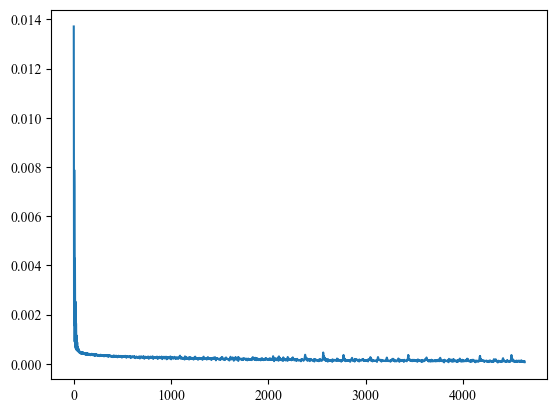

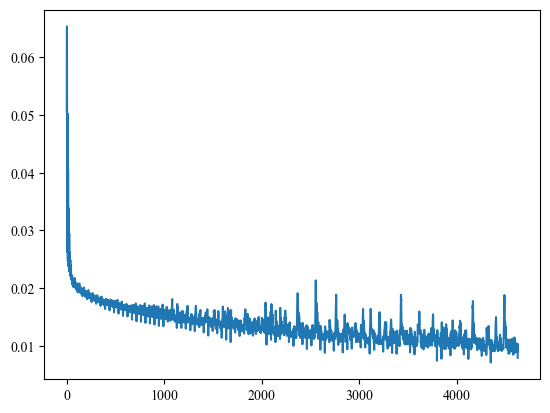

In [33]:
print(len(loss_list))

plt.figure()
plt.plot(loss_list[10:])

rmse = list( map(lambda x: x ** (1/2), loss_list) )
plt.figure()
plt.plot(rmse[20:])

In [15]:
torch.save( student_unet.state_dict(),"./results/sp500_distill_mcar0.3.pth" )

gc.collect()
torch.cuda.empty_cache()

distill_unet = SSSDS4Imputer(**model_config).cuda()
distill_unet.load_state_dict(torch.load( "./results/sp500_distill_mcar0.3.pth" ))
distill_unet.eval()


reflow_unet = SSSDS4Imputer(**model_config).cuda()
reflow_unet.load_state_dict(torch.load( "./results/sp500_reflow_mcar0.3.pth" ))
reflow_unet.eval()

In [28]:
'-----------computation overhead-----------'

X_t = X_T_acc.permute(0, 2, 1).cuda()
distill_step = 1
eps = 0
t = torch.linspace(eps, 1 - eps, distill_step + 1).cuda()
t = t * T_acc 
t= t.int()


start_time = time.time()

with torch.no_grad():  
    for i in range(1, len(t)):
        t_prev = t[i - 1]
        t_prev = t_prev * torch.ones((X_t.shape[0], 1)).cuda()  
        
        with torch.no_grad():      
            pred_v = distill_unet( (X_t, X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), t_prev.view(X_t.shape[0], 1),) )   
        X_t = X_t + ( ( t[i-1] - t[i] )/T_acc ) * pred_v 

end_time = time.time()
execution_time = end_time - start_time   
print(execution_time)  

0.05185198783874512


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.019688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.707306
[t-SNE] KL divergence after 500 iterations: 1.164359


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

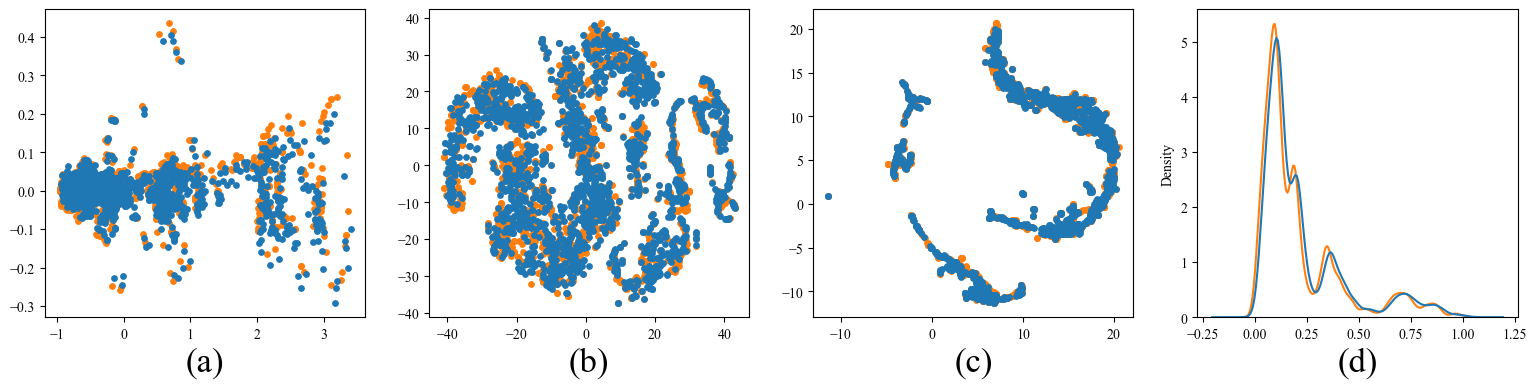

In [57]:
ori = training_data.cpu()
gen = X_t.permute(0, 2, 1).cpu().numpy()
visualization2(ori, gen)


In [59]:
'------RMSE-----'
gt = training_data
result = X_t.permute(0, 2, 1)
loss = nn.MSELoss()
output4 = loss(input=result*(1-Mask), target=gt*(1-Mask)  )       
print(output4, torch.sqrt(output4))


tensor(0.0002, device='cuda:0') tensor(0.0132, device='cuda:0')


In [60]:
X_t = X_T_acc.permute(0, 2, 1).cuda()
n_steps = 30
t = torch.linspace(eps, 1 - eps, n_steps + 1).cuda()
t = t * T_acc 
t= t.int()


start_time = time.time()

for i in range(1, len(t)):
    t_prev = t[i - 1]
    t_prev = t_prev * torch.ones((X_t.shape[0], 1)).cuda()  

    with torch.no_grad():         
        pred_v = reflow_unet( (X_t,  X_0_hat.permute(0, 2, 1), Mask.permute(0, 2, 1), t_prev.view(X_t.shape[0], 1),) )   
        
    X_t = X_t + ( ( t[i-1] - t[i] )/T_acc ) * pred_v 

print(X_t.shape)

end_time = time.time()
execution_time = end_time - start_time  
print(execution_time)  

torch.Size([5775, 6, 30])
26.867710828781128


In [63]:
gt = training_data
result = X_t.permute(0, 2, 1)
loss = nn.MSELoss()
output4 = loss(input=result*(1-Mask), target=gt*(1-Mask)  )     
print(output4, torch.sqrt(output4))

tensor(0.0002, device='cuda:0') tensor(0.0127, device='cuda:0')


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.019013
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.536842
[t-SNE] KL divergence after 500 iterations: 1.128919


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

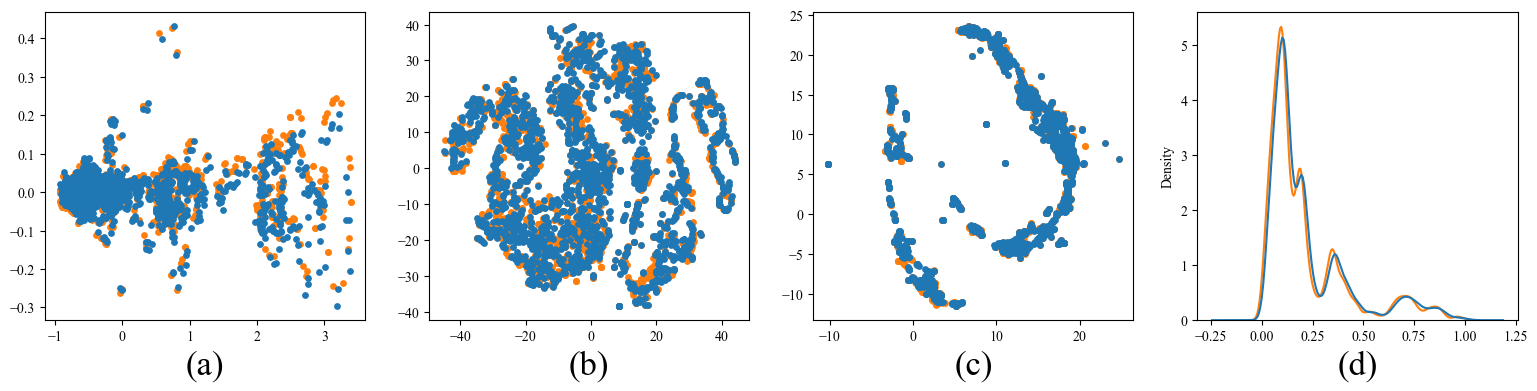

In [64]:
ori = training_data.cpu()
gen = X_t.permute(0, 2, 1).cpu().numpy()
visualization2(ori, gen)